In [1]:
from landmark_detection.pipeline import Pipeline_Yolo_CVNet_SG
from benchmark.database import build_image_database
from landmark_detection.utils import show_image, show_bboxes
from benchmark.revisitop.evaluate import compute_map

import os
import pandas as pd
import pickle
import numpy as np

In [2]:
pipeline = Pipeline_Yolo_CVNet_SG(
        detector_file = "yolov8n-oiv7.pt",
        extractor_onnx_file = "cvnet-sg-v1.onnx",
        pipeline_onnx_file = "pipeline-yolo-cvnet-sg-v1.onnx",
        image_dim = (640, 640),
        allowed_classes = [41,68,70,74,87,95,113,144,150,158,164,165,193,205,212,224,257,
                                      298,310,335,351,354,390,393,401,403,439,442,457,466,489,510,512,
                                      514,524,530,531,543,546,554,565,573,580,587,588,591],
        score_thresh = 0.10,
        iou_thresh = 0.45,
        scales = [0.7071, 1.0, 1.4142],
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225],
        rgem_pr = 2.5,
        rgem_size = 5,
        gem_p = 4.6,
        sgem_ps = 10.0,
        sgem_infinity = False,
        eps = 1e-8  
)

Creando versión ONNX del detector
Ultralytics 8.3.146  Python-3.11.11 torch-2.7.0+cpu CPU (Intel Core(TM) i5-9300HF 2.40GHz)
YOLOv8n summary (fused): 72 layers, 3,492,527 parameters, 0 gradients, 10.5 GFLOPs

PyTorch: starting from 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 605, 8400) (6.9 MB)

ONNX: starting export with onnx 1.17.0 opset 16...
ONNX: slimming with onnxslim 0.1.54...
ONNX: export success  1.6s, saved as 'C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx' (13.5 MB)

Export complete (2.2s)
Results saved to C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models
Predict:         yolo predict task=detect model=C:\Users\rdiaz\Documents\GitHub\landmark-detection-with-retrieval\landmark_detection\models\yolov8n-oiv7.onnx imgsz=640  
Validate:        yolo 

In [3]:
# Paths
CLASS_NAMES_PATH = os.path.join("oiv7.yaml")
PIPELINE_CONFIG_PATH = os.path.join("configs", "pipeline-yolo-cvnet-sg-v1")
DATASETS_PATH = os.path.abspath("datasets")

# Dataset Oxford
ROXFORD5K_PATH = os.path.join(DATASETS_PATH, "roxford5k", "jpg")
ROXFORD5K_PKL = os.path.join(DATASETS_PATH, "roxford5k", "gnd_roxford5k.pkl")
ROXFORD5K_CSV = os.path.join(DATASETS_PATH, "roxford5k", "roxford5k_image_data.csv")
ROXFORD5K_DF = os.path.join(DATASETS_PATH, "roxford5k", "results", "df_roxford5k-v1.pkl")
ROXFORD5K_DESC = os.path.join(DATASETS_PATH, "roxford5k", "results", "desc_roxford5k-v1.pkl")

# Dataset Paris
RPARIS6K_PATH = os.path.join(DATASETS_PATH, "rparis6k", "jpg")
RPARIS6K_PKL = os.path.join(DATASETS_PATH, "rparis6k", "gnd_rparis6k.pkl")
RPARIS6K_CSV = os.path.join(DATASETS_PATH, "rparis6k", "rparis6k_image_data.csv")
RPARIS6K_DF = os.path.join(DATASETS_PATH, "rparis6k", "results", "df_rparis6k-v1.pkl")
RPARIS6K_DESC = os.path.join(DATASETS_PATH, "rparis6k", "results", "desc_rparis6k-v1.pkl")

In [4]:
pipeline.to_json(PIPELINE_CONFIG_PATH)

In [6]:
df_result, descriptors_final = build_image_database(
    pipeline,
    image_folder = RPARIS6K_PATH,
    df_pickle_path = RPARIS6K_DF,
    descriptor_pickle_path = RPARIS6K_DESC,
)

Procesando imágenes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6392/6392 [1:43:39<00:00,  1.03it/s]


In [7]:
df_result.shape

(20202, 4)

In [8]:
descriptors_final.shape

(20202, 2048)

In [9]:
from benchmark.revisitop.dataset import configdataset

# Set test dataset: roxford5k | rparis6k
test_dataset = 'rparis6k'

#---------------------------------------------------------------------
# Evaluate
#---------------------------------------------------------------------

print('>> {}: Evaluating test dataset...'.format(test_dataset)) 
# config file for the dataset
# separates query image list from database image list, when revisited protocol used
cfg = configdataset(test_dataset, DATASETS_PATH)

>> rparis6k: Evaluating test dataset...


In [10]:
query_image_names = np.array(cfg['qimlist']) + cfg['ext']
q_idx_map = {name: idx for idx, name in enumerate(query_image_names)}
df_result['q_img_id'] = np.nan
df_result.loc[:, 'q_img_id'] = df_result.loc[:, 'image_name'].map(q_idx_map)
df_result['q_img_id'] = df_result['q_img_id'].fillna(-1).astype(int)

In [11]:
db_image_names = np.array(cfg['imlist']) + cfg['ext']
db_idx_map = {name: idx for idx, name in enumerate(db_image_names)}
df_result['db_img_id'] = np.nan
df_result.loc[:, 'db_img_id'] = df_result.loc[:, 'image_name'].map(db_idx_map)
df_result['db_img_id'] = df_result['db_img_id'].fillna(-1).astype(int)

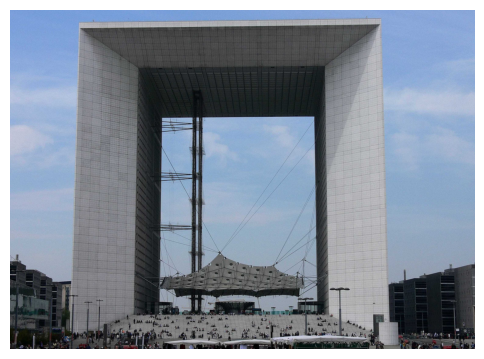

In [54]:
TEST_IMAGE_NAME = query_image_names[0]
TEST_IMAGE_PATH = os.path.join(RPARIS6K_PATH, TEST_IMAGE_NAME)
show_image(TEST_IMAGE_PATH)

In [47]:
df_filtered = df_result[df_result['image_name'] == TEST_IMAGE_NAME]
bboxes = df_filtered['bbox'].apply(list).tolist()
cls = df_filtered['class_id'].tolist()
scores = df_filtered['confidence'].tolist()
bbox_gnd = cfg['gnd'][0]['bbx']

Encontradas 7 cajas:
  Clase -1 full image @ 1.00 → [0.0,0.0,1022.4,745.8]
  Clase 466 Skyscraper @ 0.26 → [830.2,551.4,1023.7,727.3]
  Clase 466 Skyscraper @ 0.22 → [133.2,33.0,340.0,713.3]
  Clase 546 Tower @ 0.22 → [122.5,16.6,865.2,751.3]
  Clase 466 Skyscraper @ 0.21 → [668.4,12.8,843.8,704.0]
  Clase 466 Skyscraper @ 0.12 → [0.1,535.3,129.5,733.6]
  Clase 587 Window @ 0.11 → [286.5,117.5,704.5,695.1]


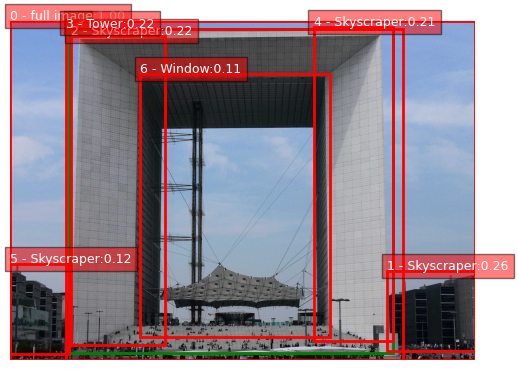

In [48]:
show_bboxes(TEST_IMAGE_PATH, CLASS_NAMES_PATH, bboxes, cls, scores, bbox_gnd)

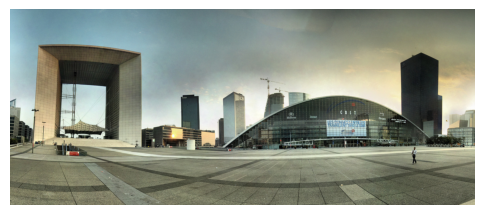

In [62]:
DB_TEST_IMAGE_NAME = db_image_names[cfg['gnd'][0]['easy'][10]]
DB_TEST_IMAGE_PATH = os.path.join(RPARIS6K_PATH, DB_TEST_IMAGE_NAME)
show_image(DB_TEST_IMAGE_PATH)

In [63]:
df_filtered = df_result[df_result['image_name'] == DB_TEST_IMAGE_NAME]
bboxes = df_filtered['bbox'].apply(list).tolist()
cls = df_filtered['class_id'].tolist()
scores = df_filtered['confidence'].tolist()
bbox_gnd = cfg['gnd'][0]['bbx']

Encontradas 11 cajas:
  Clase -1 full image @ 1.00 → [0.0,0.0,1022.4,430.3]
  Clase 546 Tower @ 0.40 → [851.9,93.1,960.5,291.4]
  Clase 70 Building @ 0.32 → [289.2,253.2,448.2,306.0]
  Clase 70 Building @ 0.24 → [477.3,186.3,916.6,308.2]
  Clase 466 Skyscraper @ 0.20 → [47.2,76.5,294.2,301.2]
  Clase 466 Skyscraper @ 0.20 → [555.4,174.6,662.5,239.9]
  Clase 466 Skyscraper @ 0.18 → [374.1,187.1,418.8,266.3]
  Clase 466 Skyscraper @ 0.17 → [458.5,180.2,520.7,303.7]
  Clase 70 Building @ 0.16 → [0.1,193.0,52.3,300.0]
  Clase 70 Building @ 0.14 → [960.3,218.3,1023.8,302.3]
  Clase 70 Building @ 0.12 → [1.2,34.3,1018.3,342.5]


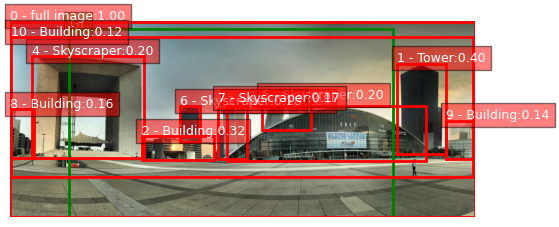

In [64]:
show_bboxes(DB_TEST_IMAGE_PATH, CLASS_NAMES_PATH, bboxes, cls, scores, bbox_gnd)

In [76]:
from benchmark.evaluation import run_evaluation
run_evaluation(df_result, descriptors_final, 'rparis6k')

>> rparis6k: Evaluating test dataset...
>> rparis6k: Loading features...
>> rparis6k: Retrieval...
>> rparis6k: mAP E: 10.43, M: 13.62, H: 9.66
>> rparis6k: mP@k[ 1  5 10] E: [       8.57        7.71        8.43], M: [      11.43       10.29       10.43], H: [      11.43       10.29        9.86]
